# Visualisation des données sur les incidents de sécurité sur le réseau de la SCNF

In [359]:
############ Installation préalable ##############
#!pip install pywaffle
#!pip install wordcloud
#!pip install deplacy
#!pip install spacy
#!python -m spacy download fr_core_news_sm

In [2]:
############ Importation des modules nécessaires ##############
import warnings # gestion des messages d'avertissement
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime  #pour la gestion des dates
from pywaffle import Waffle
import wordcloud
from wordcloud import WordCloud
import nltk
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('punkt')

########### Importation du jeu de données ############
incident= pd.read_csv("incident.csv")
incident.head()

,id,origine,numero_isic,type_event,date,nature,region,lieu,niveau_gravite,annee
0,18212,Mobilités,0,Dépassement de la vitesse limite de plus de 40...,2015-01-12,Dépassement de vitesse supérieur à 40 km/h,RA,Montbrison (42),NaN,2015
1,18152,Réseau,NaN,RFC,2015-01-14,"Un TGV franchi le PN 25 barrières hautes, la s...",PCA,Lunel (34),NaN,2015
2,18196,Réseau,NaN,Défaillance voie,2015-01-19,Défaut de géométrie nécessitant l'arrêt des ci...,LR,Entre Sète et Le Castellas,NaN,2015
3,18203,Mobilités,17347,Franchissement intempestif d'un signal d'arrêt...,2015-01-20,Le signal C348 est franchit fermé par le train...,CEN,Orléans,NaN,2015
4,18379,Réseau,17477,Engagement intempestif d'un train sur une voie...,2015-02-04,Engagement intempestif d'une circulation sur u...,RA,Lyon Perrache (69),NaN,2015


In [351]:
######## Retrait des données de 2015 ###########
incident['annee']=incident['date'].dt.strftime('%Y')
incident2=incident.drop(incident[incident['annee']=="2015"].index, inplace=False)

## En moyenne, sur la période de 2016 à 2022, quelles sont les régions dans lesquelles les incidents sont les plus graves? 

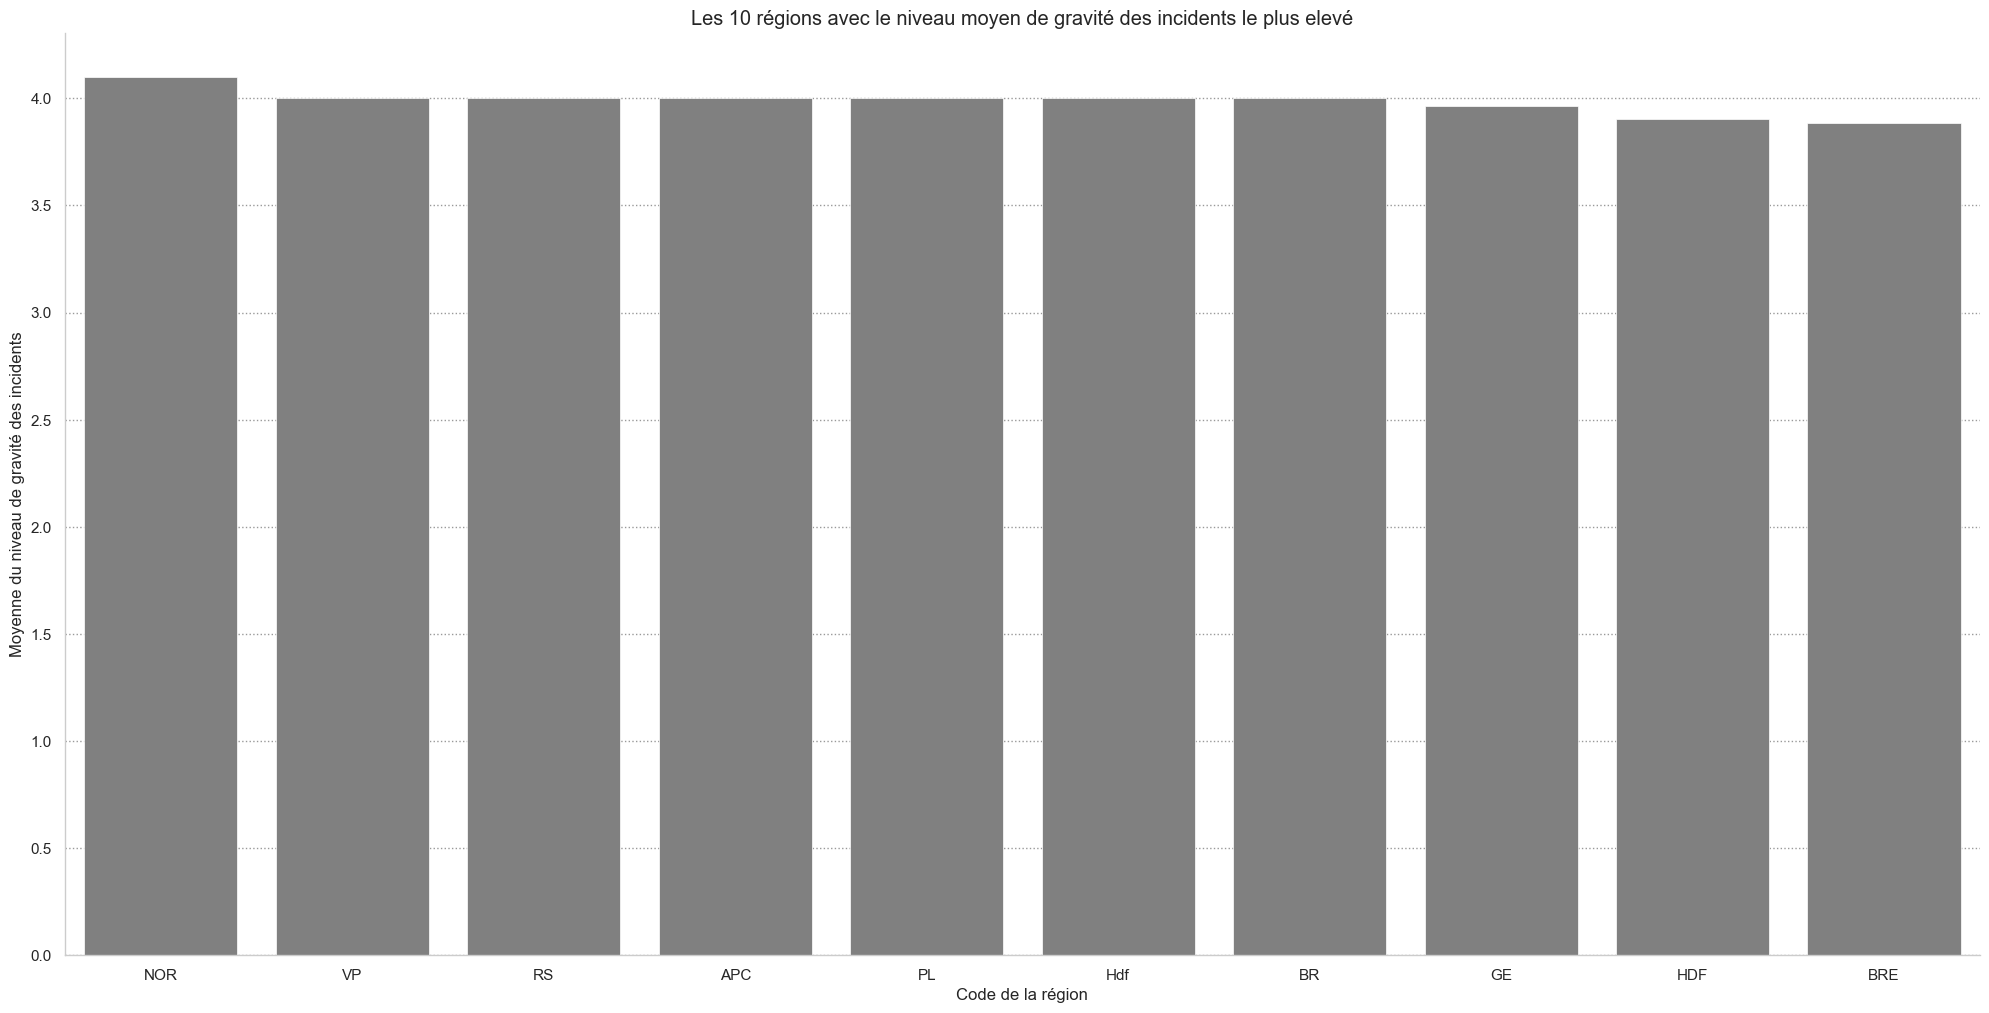

In [352]:
df1=incident2.groupby('region').agg({'niveau_gravite': "mean"}).sort_values('niveau_gravite', ascending = False).head(10)
df1=df1.reset_index()
#sns.set(style="darkgrid")
g = sns.catplot(x='region', y='niveau_gravite', data=df1, kind = "bar", height = 10, aspect = 2, color='gray')
g.set_axis_labels('Code de la région', 'Moyenne du niveau de gravité des incidents')
plt.title('Les 10 régions avec le niveau moyen de gravité des incidents le plus elevé')
plt.show()

## Comment sont répartis les incidents survenus par année?

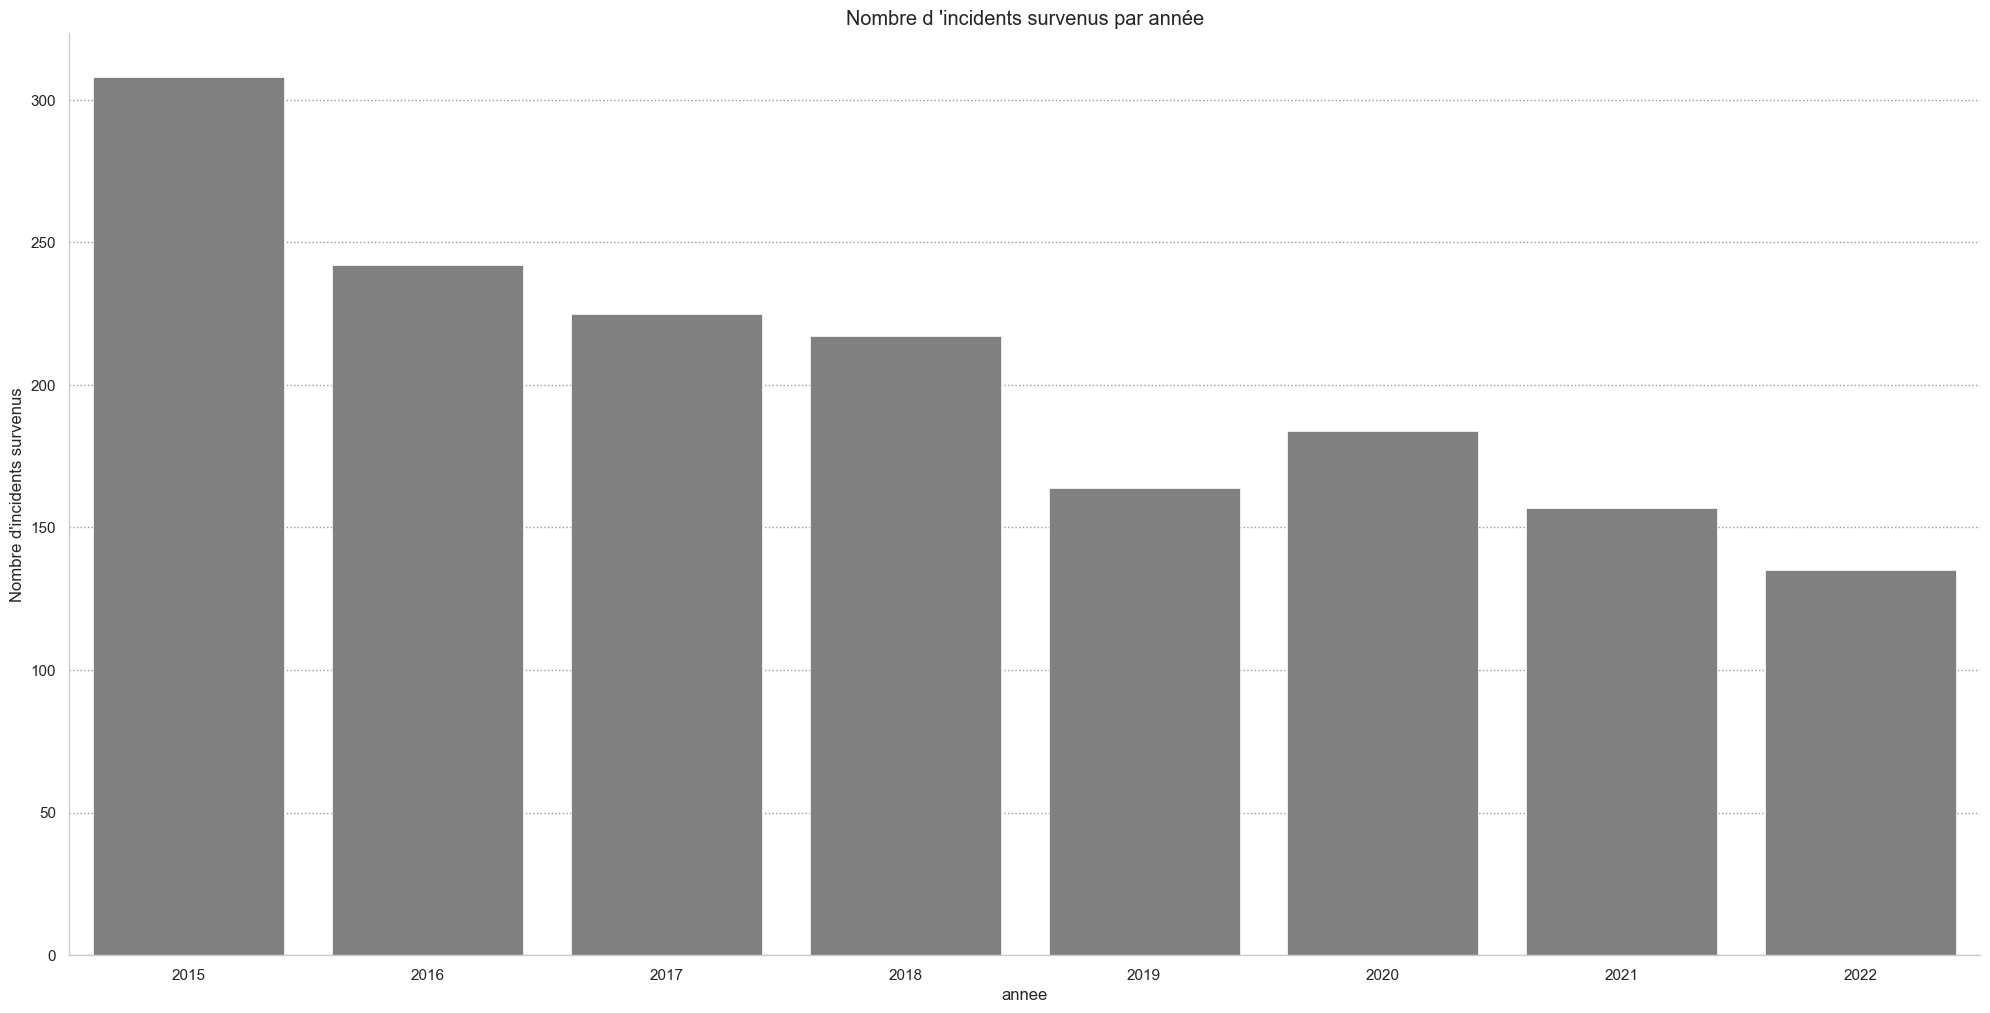

In [353]:
df2=incident.groupby('annee').agg({'annee': "count"})
df2.rename(columns = {'annee':'occurence'}, inplace = True)
df2=df2.reset_index()
g1 = sns.catplot(x='annee', y='occurence', data=df2, kind = "bar", height = 10, aspect = 2, color='gray')
g1.set_axis_labels('annee', 'Nombre d\'incidents survenus')
plt.title('Nombre d \'incidents survenus par année')
plt.show()

## Evolution du niveau de gravité moyen des incidents survenus depuis 2016

Text(0, 0.5, 'Niveau de gravité moyen')

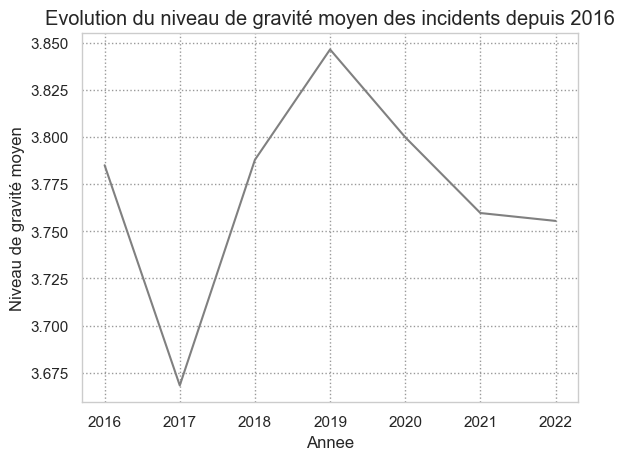

In [354]:
df3=incident2.groupby('annee').agg({'niveau_gravite': "mean"})
df3=df3.reset_index()
sns.set_style("whitegrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(df3['annee'], df3['niveau_gravite'], "gray")
plt.title('Evolution du niveau de gravité moyen des incidents depuis 2016')
plt.xlabel('Annee')
plt.ylabel('Niveau de gravité moyen')

## Quels sont les types d'incidents qui surviennent le plus souvent?

In [355]:
df4=incident.groupby('type_event').agg({'type_event': "count"})
df4.rename(columns = {'type_event':'nb_occurence'}, inplace = True)
df4=df4.sort_values('nb_occurence', ascending = False).head(10)
df4

,nb_occurence
type_event,
Franchissement intempestif d'un signal d'arrêt fermé,183
Défaillance voie,175
Dépassement de la vitesse limite de plus de 40 km/h,155
Expédition d'un train sans ordre écrit de restriction de vitesse,130
Incident grave de signalisation,124
RFC,90
Portes ouvertes sur train de voyageurs en circulation,78
Déraillement,75
Incendie à bord d’un train,64


## Comment évoluent les occurences de ces types d'incidents dans le temps?

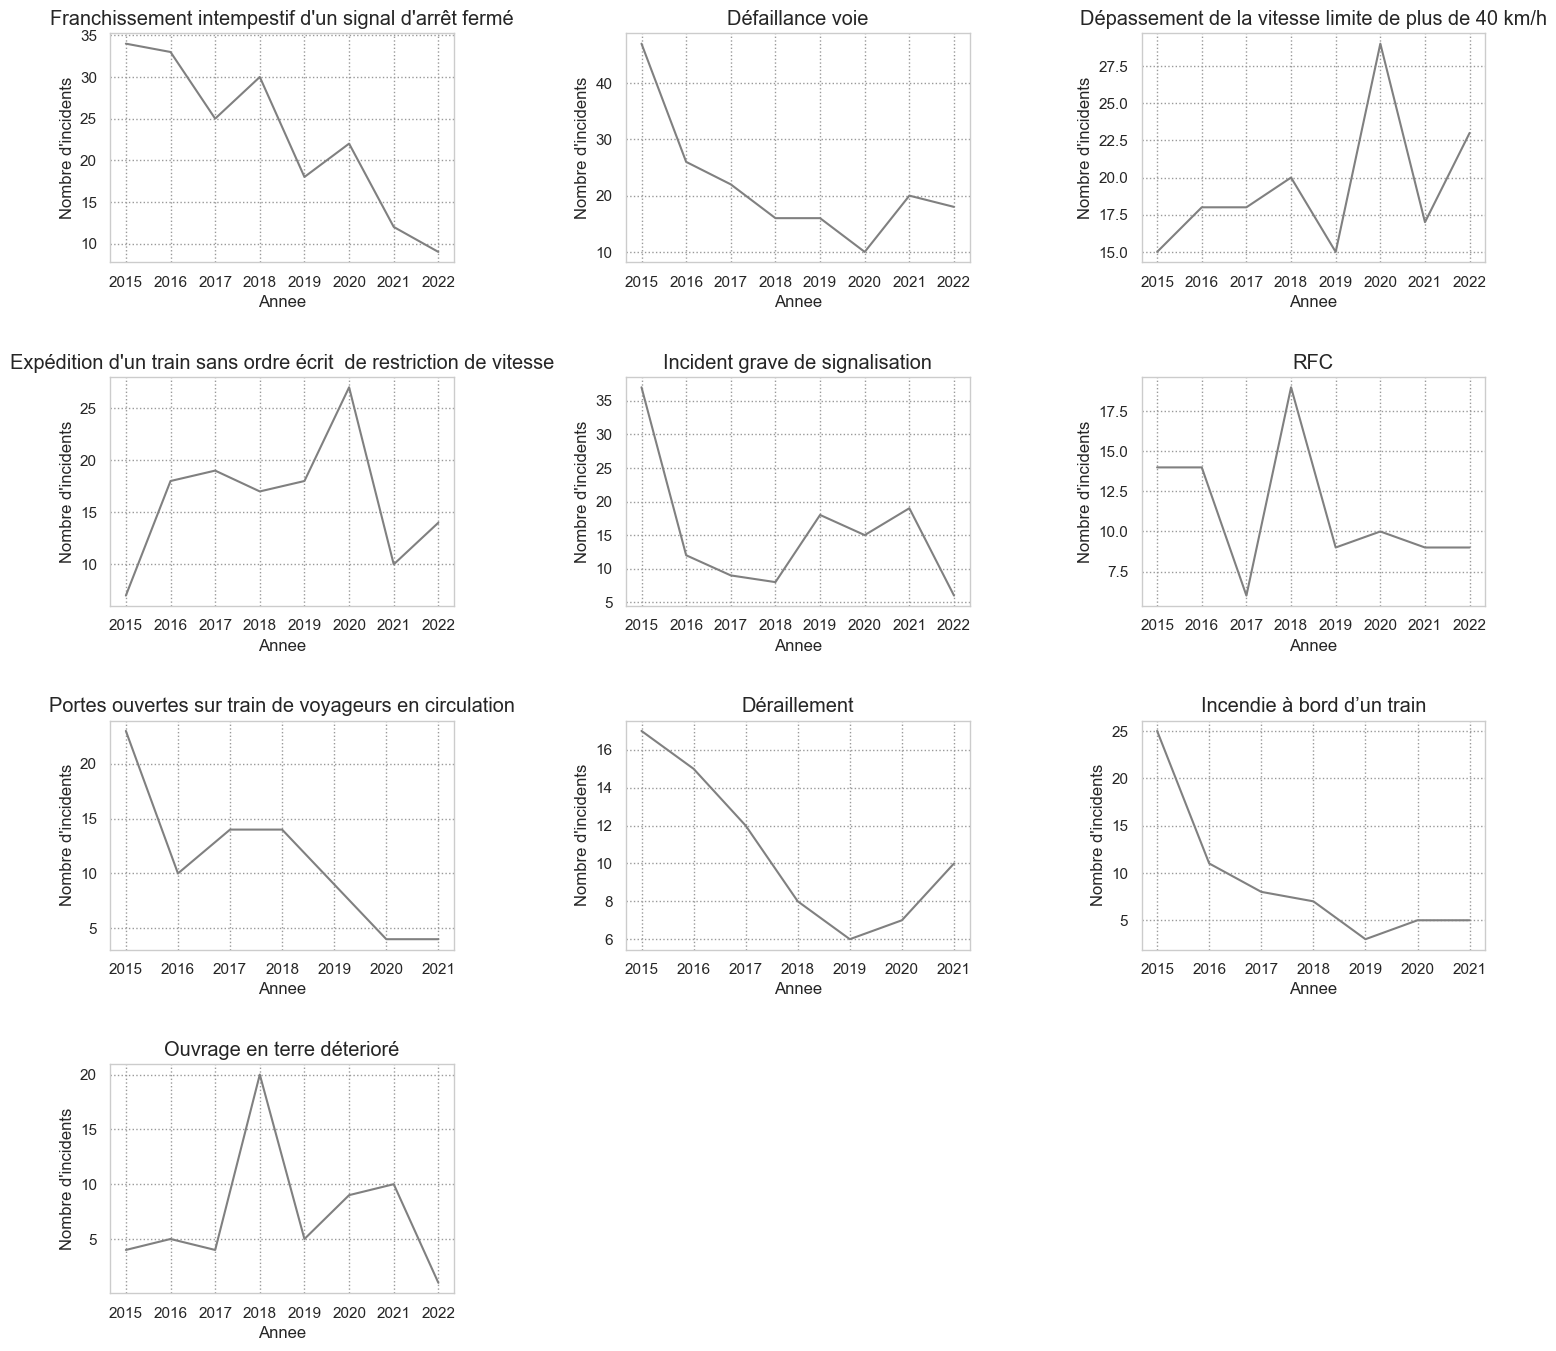

In [356]:
freq_event=np.array(df4.index)
plt.figure(1,figsize=(10,18))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,top = 0.9, wspace = 0.5, hspace = 0.5)
for i in range(len(freq_event)):
    plt.subplot(4,3,i+1)
    df=incident[incident['type_event']==freq_event[i]].groupby('annee').agg({'type_event':"count"})
    plt.plot(df.index, df['type_event'], "gray")
    plt.xlabel('Annee')
    plt.ylabel('Nombre d\'incidents')
    plt.title(freq_event[i])

## Mais quelles sont les origines de tous ces incidents de sécurité survenus sur le réseau de la SNCF?🤔

Text(0.5, 1.0, 'Origines des incidents')

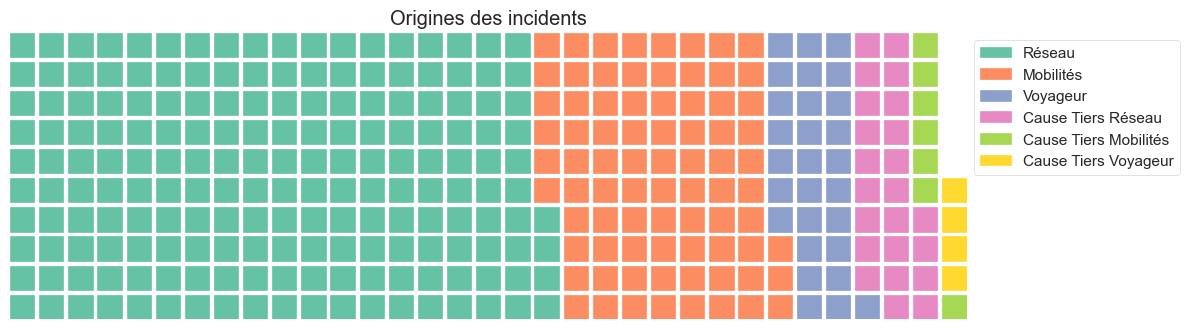

In [357]:
df=incident.groupby('origine').agg({'origine': "count"})
df.rename(columns = {'origine':'nb_occurence'}, inplace = True)
df=df.sort_values('nb_occurence', ascending = False)
df=df.head(6)
fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=list(df.nb_occurence/5),
    labels=list(df.index),
    figsize=(12, 8),
    legend={'bbox_to_anchor': (1,1)}
)
plt.title('Origines des incidents')

## Résumé sur les différentes natures des incidents
Le nuage de mots clés est une sorte de condensé sémantique d'un texte dans lequel les concepts clefs évoqués sont dotés d'une unité de taille (dans le sens du poids de la typographie utilisée) permettant de faire ressortir leur importance dans le texte.

In [3]:
## Transformation de la variable nature en corpus de texte
texte = str([i for i in incident.nature]) 
texte = texte.lower() # mettre les mots en minuscule

# Creation d'un object doc 
nlp=spacy.load("fr_core_news_sm")
doc = nlp(texte)

# collect each token separately with their POS Tag, dependencies and lemma
token_list = []
for token in doc:
    output = [token.text, token.pos_, token.dep_,token.lemma_]
    token_list.append(output)

# create DataFrame using data 
df = pd.DataFrame(token_list, columns =['Word', 'POS Tag', 'Dependencies', 'Lemmatized Word'])
df.head()

,Word,POS Tag,Dependencies,Lemmatized Word
0,[,PUNCT,punct,[
1,',PUNCT,punct,'
2,dépassement,NOUN,obl:mod,dépassement
3,de,ADP,case,de
4,vitesse,NOUN,nmod,vitesse


In [4]:
# Removing noise
df_nopunct = df[df['POS Tag']!='PUNCT']
df_nopunct.head()

,Word,POS Tag,Dependencies,Lemmatized Word
2,dépassement,NOUN,obl:mod,dépassement
3,de,ADP,case,de
4,vitesse,NOUN,nmod,vitesse
5,supérieur,ADJ,amod,supérieur
6,à,ADP,case,à


In [12]:
# Removing stopwords
lemma_word = df_nopunct['Lemmatized Word'].values.tolist()
stopword = nlp.Defaults.stop_words

# Add the word to the set of stop words. Use lowercase!
nlp.Defaults.stop_words.add('btw')
stop_words_contexte=["train", "trains", "sncf", "ter", "après", "alors", "sans", "tgv", "réseau", "gare", "voie", "lors", "suite",
"conducteur", "voyageur", "voyageurs", "circulation", "agent", "agents","passager", "passagers", "entre", "plusieurs", "entre",
"circulations", "passage", "non", "avant", "voies", "circule", "plus"]
stopword=list(stopword)+stop_words_contexte
def check_stop(word):
    if word in stopword:
        return(True)
    else:
        return(False)
is_stopword_list = []
for word in lemma_word:
    is_stopword = check_stop(word)
    is_stopword_list.append(is_stopword)
is_stopword_list=[str(i) for i in is_stopword_list]
df_nopunct["is_stopword"] = np.array(is_stopword_list)
clean_df = df_nopunct[df_nopunct["is_stopword"]=="False"]
clean_df.head()
#is_stopword_list

,Word,POS Tag,Dependencies,Lemmatized Word,is_stopword
2,dépassement,NOUN,obl:mod,dépassement,False
4,vitesse,NOUN,nmod,vitesse,False
5,supérieur,ADJ,amod,supérieur,False
7,40,NUM,nummod,40,False
8,km,NOUN,obl:arg,kilomètre,False


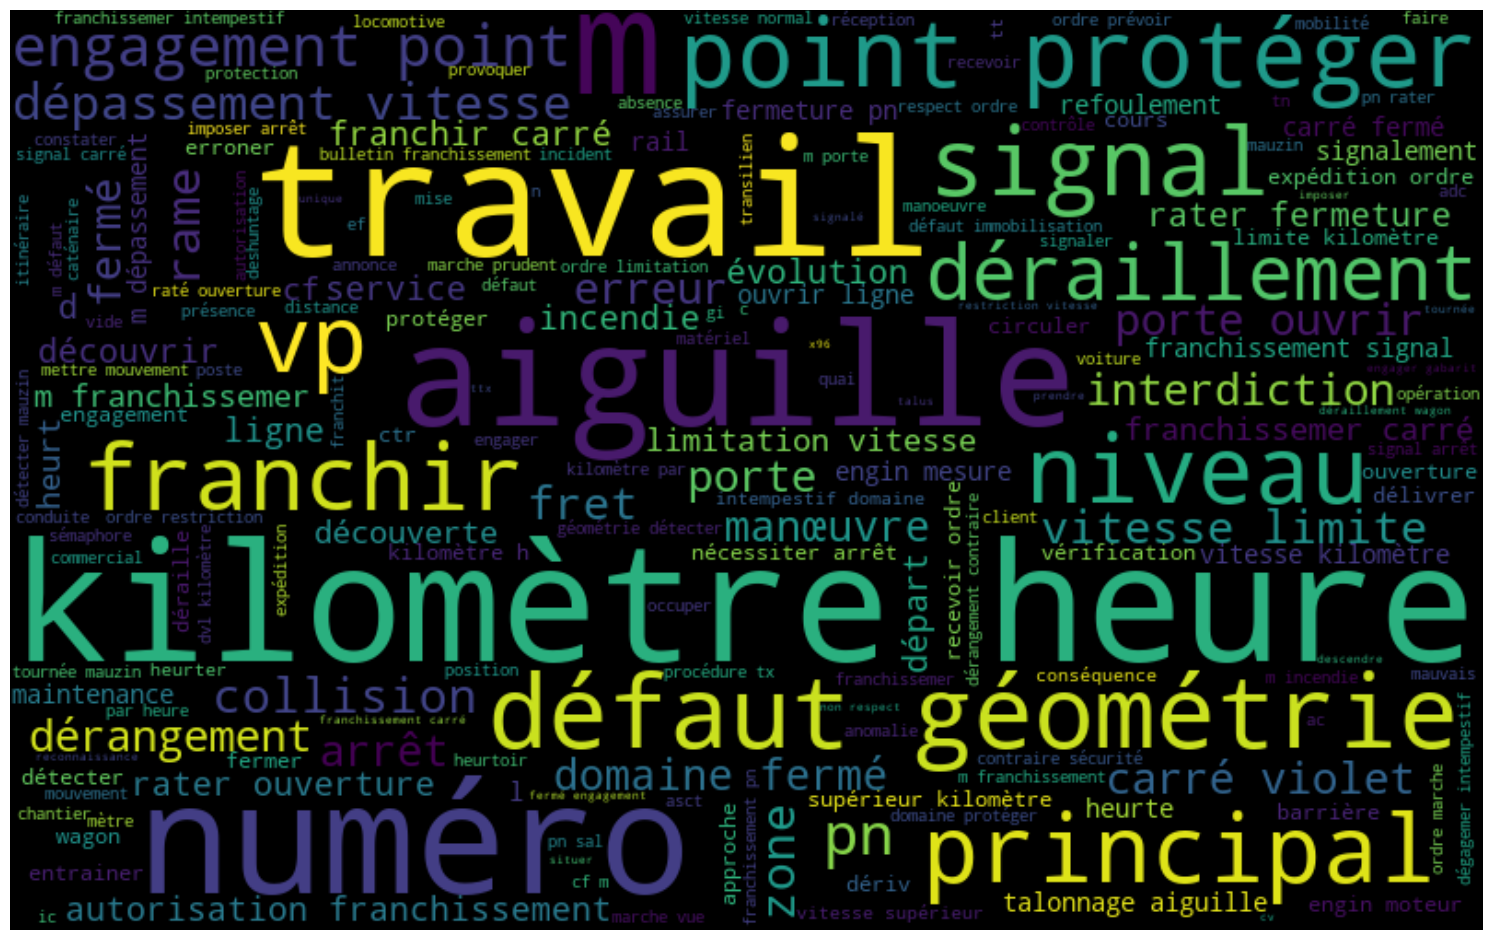

In [13]:
# Obtain the cleaned tokens
clean_list = clean_df["Lemmatized Word"].values.tolist()
# Wordcloud
wc2=" ".join(clean_list)
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(wc2)
plt.figure(figsize=(19, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

Avec ce nuage, on voit les idées clés et donc importantes concernant les natures des différents incidents survenus sur le réseau de la SNCF.

## Lieux où surviennent le plus les incidents dans la région île-de-france 💡

Text(0.5, 1.0, 'Les incidents en IDF')

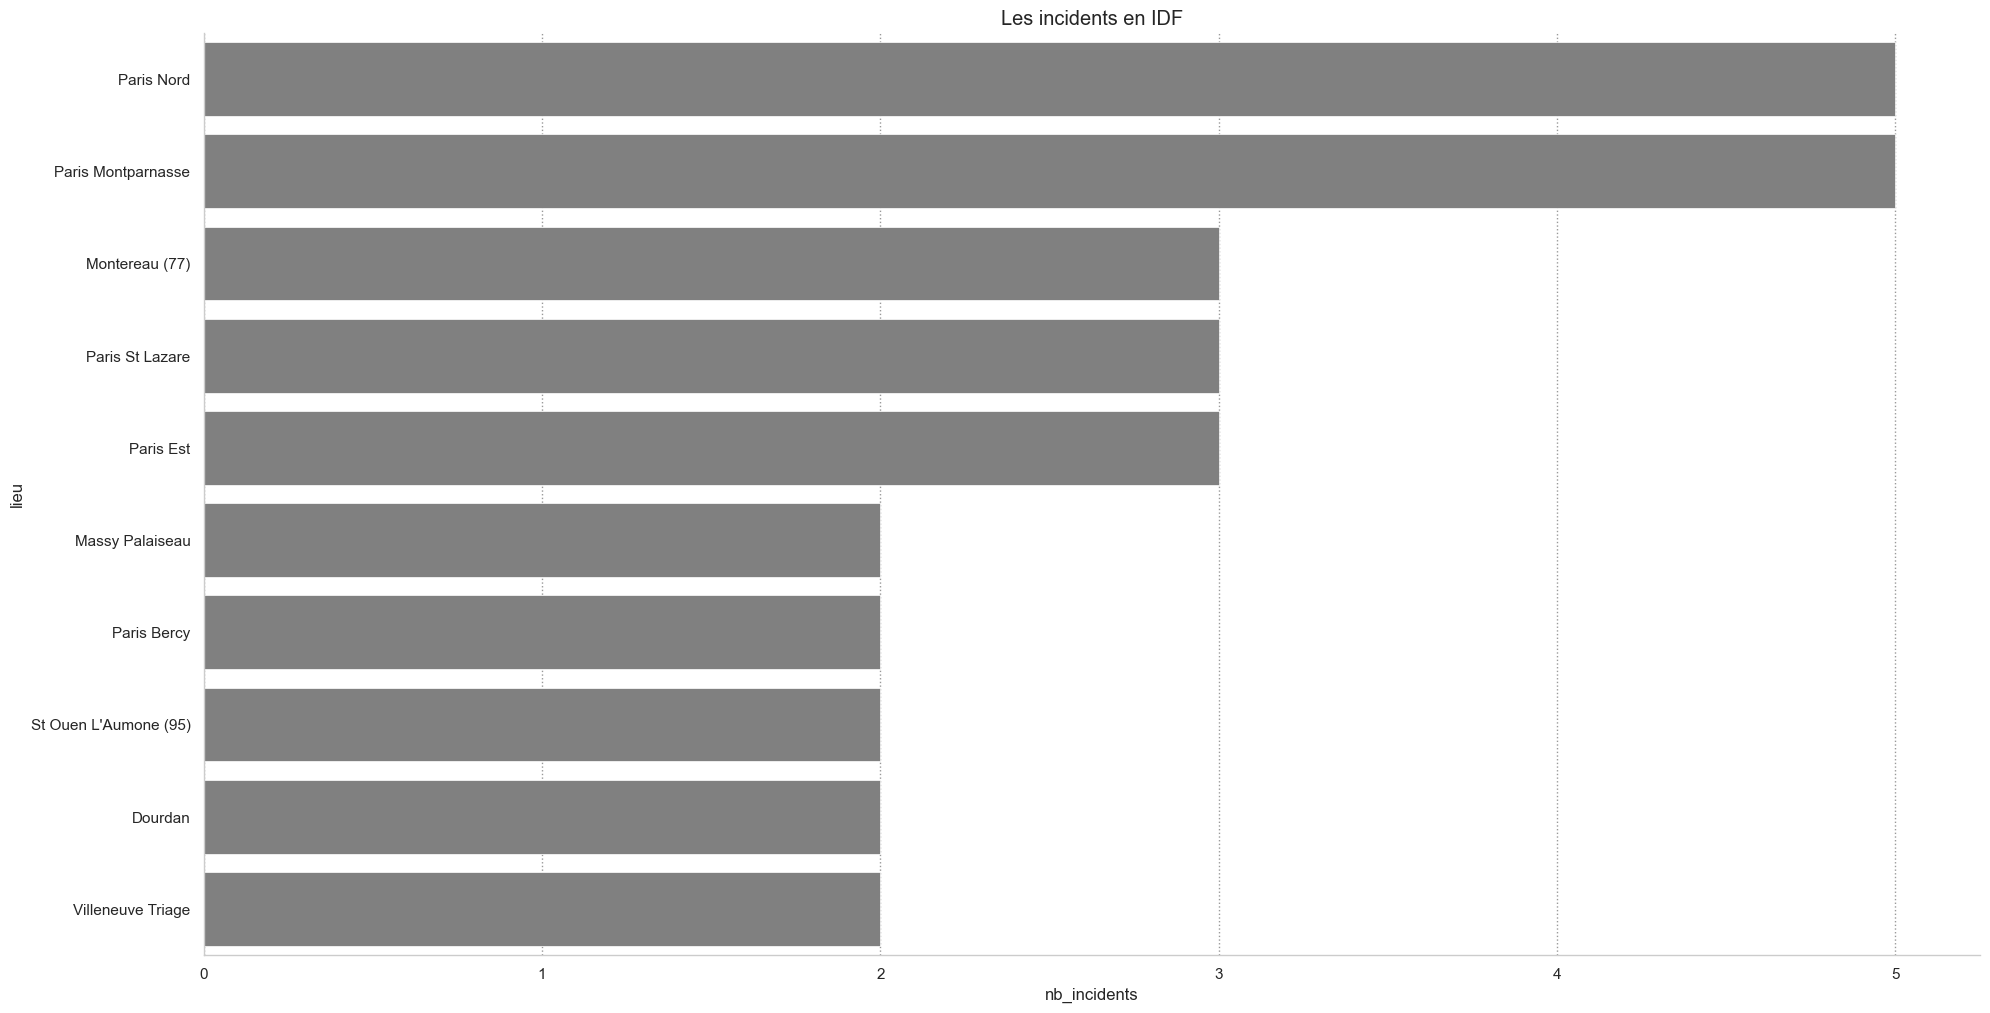

In [348]:
df4=incident[incident['region']=='IDF']
df4=df4.groupby('lieu').agg({'lieu': "count"})
df4.rename(columns = {'lieu':'nb_incidents'}, inplace = True)
df4=df4.sort_values('nb_incidents', ascending = False).head(10)
df4=df4.reset_index()
sns.catplot(x='nb_incidents', y='lieu', data=df4, kind = "bar", height = 10, aspect = 2, color='gray')
plt.title('Les incidents en IDF')